# Library Installation

In [ ]:
!pip install livelossplot==0.5.1 --quiet

# Imports and Drive Mount

In [ ]:
import gc
import pickle
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.optim as optim
import cv2 as cv
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models
from skimage.transform import resize 
from torch.utils.data import random_split, DataLoader, Dataset, ConcatDataset

from PIL import Image

from matplotlib import pyplot as plt

from livelossplot import PlotLosses

from google.colab import drive
from os import listdir
from sys import getsizeof
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# custom dataset for fetching images from the .h5 file (improved performance)
class h5Dataset(Dataset):

    def __init__(self, file_path, func=None):
        # file_path: path to .h5 file
        self.file = h5py.File(file_path + "DIML.h5", "r")

        self.func = func

        self.rgb_dbs = sorted([key for key in self.file.keys() \
                                if key[:3] == "rgb"])
        self.depth_dbs = sorted([key for key in self.file.keys() \
                                if key[:5] == "depth"])
        
        #self.totens = transforms.ToTensor()

    def __getitem__(self, index):
        
        #rgb = self.file[self.rgb_dbs[index]][:].astype('float64') / 255
        rgb = self.file[self.rgb_dbs[index]][:]
        #depth = self.file[self.depth_dbs[index]][:].astype('float64')
        depth = self.file[self.depth_dbs[index]][:]

        if self.func:
            rgb, depth = self.func(rgb, depth)
        
        #rgb = self.totens(rgb)
        #depth = self.totens(depth)
            
        return rgb, depth
        '''
        rgb = resize(self.file[self.rgb_dbs[index]][:], (480, 640), 
                     anti_aliasing=True)
        depth = resize(self.file[self.depth_dbs[index]][:], (480, 640),
                       anti_aliasing=True)
        
        print(self.file[self.rgb_dbs[index]][:])

        rgb = self.totens(np.array(rgb, dtype='float64') / 255.0)
        depth = self.totens(np.array(depth, dtype='float64') / 65535.0)
        
        return rgb, depth
        '''
    
    def __len__(self):
        return min(len(self.rgb_dbs), len(self.depth_dbs))

class h5DatasetSlice(Dataset):

    def __init__(self, file_path, func=None, ratios=(0, 1)):
        # file_path: path to .h5 file
        self.file = h5py.File(file_path + "DIML.h5", "r")
        self.func = func

        self.rgb_dbs = sorted([key for key in self.file.keys() \
                                if key[:3] == "rgb"])
        self.depth_dbs = sorted([key for key in self.file.keys() \
                                if key[:5] == "depth"])
        ratios = [int(k*len(self.rgb_dbs)) for k in ratios]

        #print(ratios)

        self.rgb_dbs = self.rgb_dbs[ratios[0] : ratios[1]]
        self.depth_dbs = self.depth_dbs[ratios[0] : ratios[1]]
        
        self.totens = transforms.ToTensor()

    def __getitem__(self, index):
        
        #rgb = self.file[self.rgb_dbs[index]][:].astype('float64') / 255
        rgb = self.file[self.rgb_dbs[index]][:]
        #depth = self.file[self.depth_dbs[index]][:].astype('float64')
        depth = self.file[self.depth_dbs[index]][:]

        if self.func:
            rgb, depth = self.func(rgb, depth)
        else:
            rgb = self.totens(rgb)
            depth = self.totens(depth.astype(np.float64) / 65535.0)
            
        return rgb, depth

    
    def __len__(self):
        return min(len(self.rgb_dbs), len(self.depth_dbs))

class Interpolate(nn.Module):
    def __init__(self, scale, mode):
        super(Interpolate, self).__init__()
        self.interp = F.interpolate
        self.scale = scale
        self.mode = mode
        
    def forward(self, x):
        x = self.interp(x, scale_factor=self.scale, mode=self.mode, align_corners=False)
        return x

class SkipConv(nn.Module):
    def __init__(self, inputs, out_channels, kernel_size=3, mode="down", 
                 scale=2, default_in=3, activ=nn.LeakyReLU()):
        super(SkipConv, self).__init__()
        if isinstance(inputs, tuple):
            self.in_channels = sum([k.out_channels for k in inputs])
        elif inputs == "vgg16_bn":
            self.in_channels = 513
        elif inputs:
            self.in_channels = inputs.out_channels
        else:
            self.in_channels = default_in
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.mode = mode
        self.scale = scale
        self.activ = activ

        self.norm = nn.BatchNorm2d(self.out_channels)

        if self.mode == "down":
            self.final_pool = nn.MaxPool2d(kernel_size=self.scale, stride=self.scale)
            self.conv = nn.Conv2d(
                in_channels = self.in_channels,
                out_channels = self.out_channels,
                kernel_size = self.kernel_size,
                padding = int(self.kernel_size / 2),
                stride = self.scale
            )
        
        else:
            self.conv = nn.ConvTranspose2d(
                in_channels = self.in_channels,
                out_channels = self.out_channels,
                kernel_size = self.kernel_size,
                padding = int(self.kernel_size / 2),
                stride = self.scale,
                output_padding = 1
            )
    
    def forward(self, *x):

        if self.mode == "down":
            min_h = min([k.shape[2] for k in x])
            scaled_inputs = []
            for input in x:
                factor = int(input.shape[2] / min_h)
                pool = nn.MaxPool2d(kernel_size=factor, stride=factor)
                scaled_inputs.append(pool(input))
            
            return self.activ(self.conv(torch.cat(scaled_inputs, dim=1)))
        
        else:
            max_h = max([k.shape[2] for k in x])
            scaled_inputs = []
            for input in x:
                factor = int(max_h / input.shape[2])
                interp = Interpolate(scale=factor, mode="bilinear")
                scaled_inputs.append(interp(input))
            
            return self.activ(self.conv(torch.cat(scaled_inputs, dim=1)))

class SkipUpconv(nn.Module):
    def __init__(self, in_channels, out_channels, activ=nn.LeakyReLU(0.2)):
        super(SkipUpconv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.activ = activ
        self.norm = nn.BatchNorm2d(out_channels)
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels = out_channels,
            kernel_size = 3,
            stride = 1,
            padding = 1,
        )

    def forward(self, small, big):
        scaled = F.interpolate(small, size=big.shape[2:], mode='bilinear', 
                               align_corners=True)
        out = self.norm(self.activ(self.conv(torch.cat((scaled, big), dim=1))))

        return F.interpolate(out, scale_factor=2, mode='bilinear', 
                             align_corners=True)

class SkipEncoder1(nn.Module):
    def __init__(self):
        super(SkipEncoder1, self).__init__()

        self.norm3 = nn.BatchNorm2d(3)
        self.norm100 = nn.BatchNorm2d(100)
        self.norm200 = nn.BatchNorm2d(200)
        self.norm500 = nn.BatchNorm2d(500)

        self.interp = Interpolate(scale=2, mode='bilinear')

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv1 = nn.Conv2d(3, 100, kernel_size=21, padding=10, stride=2)
        self.conv2 = nn.Conv2d(100, 200, kernel_size=11, padding=5, stride=2)
        self.conv3 = nn.Conv2d(300, 500, kernel_size=5, padding=2, stride=2)

        self.deconv1 = nn.ConvTranspose2d(700, 200, kernel_size=5, padding=2, 
                               stride=2, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(700, 100, kernel_size=11, padding=5, 
                               stride=2, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(300, 1, kernel_size=21, padding=10, 
                               stride=2, output_padding=1)
        
        self.activ = nn.LeakyReLU()
        self.sig = nn.Sigmoid()

    def forward(self, x1):
        x2 = self.activ(self.conv1(self.norm3(x1)))
        x3 = self.activ(self.conv2(self.norm100(x2)))
        x4 = self.activ(self.conv3(torch.cat((self.pool(x2), self.norm200(x3)), dim=1)))

        x5 = self.activ(self.deconv1(torch.cat((self.pool(x3), self.norm500(x4)), dim=1)))
        x6 = self.activ(self.deconv2(torch.cat((self.interp(x4), self.norm200(x5)), dim=1)))
        x7 = self.sig(self.deconv3(torch.cat((self.interp(x5), self.norm100(x6)), dim=1)))

        return x7

class SkipEncoder2(nn.Module):
    def __init__(self, activ):
        super(SkipEncoder2, self).__init__()
        self.sig = nn.Sigmoid()

        self.enc1 = SkipConv(
            inputs = None,
            out_channels = 100,
            kernel_size = 7,
            mode = "down",
            scale = 2,
            activ = activ
        )
        self.enc2 = SkipConv(
            inputs = (self.enc1),
            out_channels = 200,
            kernel_size = 5,
            mode = "down",
            scale = 2,
            activ = activ
        )
        self.enc3 = SkipConv(
            inputs = (self.enc1, self.enc2),
            out_channels = 400,
            kernel_size = 3,
            mode = "down",
            scale = 2,
            activ = activ
        )
        self.enc4 = SkipConv(
            inputs = (self.enc1, self.enc2, self.enc3),
            out_channels = 800,
            kernel_size = 3,
            mode = "down",
            scale = 2,
            activ = activ
        )
        self.dec1 = SkipConv(
            inputs = (self.enc3, self.enc4),
            out_channels = 400,
            kernel_size = 3,
            mode = "up",
            scale = 2,
            activ = activ
        )
        self.dec2 = SkipConv(
            inputs = (self.enc2, self.enc3, self.enc4, self.dec1),
            out_channels = 200,
            kernel_size = 5,
            mode = "up",
            scale = 2,
            activ = activ
        )
        self.dec3 = SkipConv(
            inputs = (self.dec1, self.dec2),
            out_channels = 1,
            kernel_size = 7,
            mode = "up",
            scale = 2,
            activ = activ
        )

    def forward(self, x0):

        x1 = self.enc1(x0)
        x2 = self.enc2(x1)
        x3 = self.enc3(x1, x2)
        x4 = self.enc4(x1, x2, x3)
        x5 = self.dec1(x3, x4)
        x6 = self.dec2(x2, x3, x4, x5)
        x7 = self.sig(self.dec3(x5, x6))

        return x7

class SkipEncoder3(nn.Module):
    def __init__(self, channels=(640, 250, 100, 50, 20)):
        super(SkipEncoder3, self).__init__()

        self.mobilenet = models.mobilenet_v2(pretrained=True).cuda()
        self.enc = nn.Sequential(*list(self.mobilenet.children())[0])

        self.dec1 = nn.Conv2d(1280, channels[0], kernel_size=3, stride=1, 
                              padding=1)
        self.dec2 = SkipUpconv(channels[0]+1280, channels[1])
        self.dec3 = SkipUpconv(channels[0]+channels[1], channels[2])
        self.dec4 = SkipUpconv(channels[1]+channels[2], channels[3])
        self.dec5 = SkipUpconv(channels[2]+channels[3], channels[4])
        self.dec6 = SkipUpconv(channels[3]+channels[4], 1)

        self.sig = nn.Sigmoid()

        #print(self.enc)
    
    def forward(self, x0):
        '''
        features = [x0]
        

        for name, module in self.mobilenet.features._modules.items():
            features.append(module(features[-1]))
        
        for feature in features:
            print(feature.shape)
        '''
        

        x1 = self.enc(x0)
        x2 = self.dec1(x1)
        x3 = self.dec2(x1, x2)
        x4 = self.dec3(x2, x3)
        x5 = self.dec4(x3, x4)
        x6 = self.dec5(x4, x5)
        x7 = self.dec6(x5, x6)
        #print(x7.shape)
        return self.sig(x7)

class SkipEncoder4(nn.Module):
    def __init__(self, channels=(640, 250, 100, 50)):
        super(SkipEncoder4, self).__init__()

        self.mobilenet = models.mobilenet_v2(pretrained=True).cuda()

        self.dec1 = nn.Conv2d(1280, channels[0], kernel_size=3, stride=1, 
                              padding=1)
        self.dec2 = SkipUpconv(channels[0]+96, channels[1])
        self.dec3 = SkipUpconv(channels[1]+32, channels[2])
        self.dec4 = SkipUpconv(channels[2]+24, channels[3])
        self.dec5 = SkipUpconv(channels[3]+16, 1)

        self.sig = nn.Sigmoid()
    
    def forward(self, x0):
        features = [x0]
        for name, module in self.mobilenet.features._modules.items():
            features.append(module(features[-1]))
        
        x1 = self.dec1(features[19])
        x2 = self.dec2(x1, features[14])
        x3 = self.dec3(x2, features[7])
        x4 = self.dec4(x3, features[4])
        x5 = self.dec5(x4, features[2])

        return self.sig(x5)
        
        
        


class Generator1(nn.Module):
    def __init__(self, activ=nn.LeakyReLU()):
        super(Generator1, self).__init__()

        self.sig = nn.Sigmoid()

        self.enc1 = SkipConv(
            inputs = None,
            out_channels = 50,
            kernel_size = 3,
            mode = "down",
            scale = 2,
            default_in = 4,
            activ = activ
        )
        self.enc2 = SkipConv(
            inputs = (self.enc1),
            out_channels = 100,
            kernel_size = 3,
            mode = "down",
            scale = 2,
            activ = activ
        )
        self.enc3 = SkipConv(
            inputs = (self.enc1, self.enc2),
            out_channels = 200,
            kernel_size = 3,
            mode = "down",
            scale = 2,
            activ = activ
        )
        self.dec1 = SkipConv(
            inputs = (self.enc2, self.enc3),
            out_channels = 100,
            kernel_size = 3,
            mode = "up",
            scale = 2,
            activ = activ
        )
        self.dec2 = SkipConv(
            inputs = (self.enc3, self.dec1),
            out_channels = 1,
            kernel_size = 3,
            mode = "up",
            scale = 2,
            activ = activ
        )


    def forward(self, rgb):

        noise = torch.FloatTensor(
                np.random.normal(0, 1, (rgb.shape[0], 1, 480, 640))).cuda()

        x1 = self.enc1(torch.cat((rgb, noise), dim=1))
        x2 = self.enc2(x1)
        x3 = self.enc3(x1, x2)
        x4 = self.dec1(x2, x3)
        x5 = self.sig(self.dec2(x3, x4))

        return x5

class Generator2(nn.Module):
    def __init__(self, activ=nn.LeakyReLU(0.1)):
        super(Generator2, self).__init__()

        _resNext = models.resnext50_32x4d(pretrained=True).cuda()

        self.sig = nn.Sigmoid()

        self.ResNext = nn.Sequential(*list(_resNext.children())[:5])

        #print(self.ResNext)

        for child in self.ResNext.modules():
            for param in child.parameters():
                param.requires_grad = False
        
        self.deconv = nn.Sequential(
            #Interpolate(scale=2, mode='bilinear'),
            nn.ConvTranspose2d(257, 80, kernel_size=3, padding=1, 
                               stride=2, output_padding=1),
            activ,
            nn.BatchNorm2d(80),
            nn.ConvTranspose2d(80, 40, kernel_size=3, padding=1, 
                               stride=2, output_padding=1),
            activ,
            nn.BatchNorm2d(40),
            nn.ConvTranspose2d(40, 1, kernel_size=3, padding=1, 
                               stride=2, output_padding=1),
            nn.Tanh()
        )
        '''

        self.conv1 = SpectralNorm(nn.Conv2d(4, 40, kernel_size=7, padding=3, 
                                            stride=2))
        self.conv2 = SpectralNorm(nn.Conv2d(40, 80, kernel_size=5, padding=2, 
                                            stride=2))
        self.conv3 = SpectralNorm(nn.Conv2d(80, 160, kernel_size=3, padding=1, 
                                            stride=2))

        self.deconv1 = SpectralNorm(nn.ConvTranspose2d(160, 80, kernel_size=3, 
                                        padding=1, stride=2, output_padding=1))
        self.deconv2 = SpectralNorm(nn.ConvTranspose2d(80, 40, kernel_size=5, 
                                        padding=2, stride=2, output_padding=1))
        self.deconv3 = SpectralNorm(nn.ConvTranspose2d(40, 1, kernel_size=7, 
                                        padding=3, stride=2, output_padding=1))

        self.pool2 = nn.MaxPool2d(2, 2)
        self.pool4 = nn.MaxPool2d(4, 4)
        self.interp4 = Interpolate(scale=4, mode='bilinear')

        self.activ = activ
        self.sig = nn.Sigmoid()
        '''

    def forward(self, rgb):

        #print(self.ResNext(rgb).shape)

        x = F.interpolate(self.ResNext(rgb), size=(60, 80))
        noise = torch.FloatTensor(
                np.random.normal(0, 1, (x.shape[0], 1, 60, 80))).cuda()
        x = self.deconv(torch.cat((x, noise), dim=1))
        depth1 = np.moveaxis(np.array(x[0].detach().cpu()), 0, -1).squeeze()
        plt.imshow(depth1, cmap='gray')        
        return x
        '''
        noise = torch.FloatTensor(
                np.random.normal(0, 1, (rgb.shape[0], 1, 480, 640))).cuda()
        x1 = self.activ(self.conv1(self.pool4(torch.cat((rgb, noise), dim=1))))
        x2 = self.activ(self.conv2(x1))
        x3 = self.activ(self.conv3(x2))
        x4 = self.activ(self.deconv1(self.interp4(x3)))
        x5 = self.activ(self.deconv2(x4))
        x6 = self.sig(self.deconv3(x5))
        return x6
        '''

class Generator3(nn.Module):
    def __init__(self, activ=nn.LeakyReLU(0.1)):
        super(Generator3, self).__init__()

        _vgg16 = models.vgg16_bn(pretrained=True).cuda()

        self.VGG = nn.Sequential(*list(_vgg16.children())[:][0][:-11])

        for child in self.VGG.modules():
            for param in child.parameters():
                param.requires_grad = False
        
        #print(self.VGG)
        
        self.deconv = nn.Sequential(
            Interpolate(scale=2, mode='bilinear'),
            nn.ConvTranspose2d(513, 250, kernel_size=5, padding=2, 
                               stride=2, output_padding=1),
            activ,
            nn.BatchNorm2d(250),
            nn.ConvTranspose2d(250, 100, kernel_size=7, padding=3, 
                               stride=2, output_padding=1),
            activ,
            nn.BatchNorm2d(100),
            nn.ConvTranspose2d(100, 1, kernel_size=11, padding=5, 
                               stride=2, output_padding=1),
            nn.Tanh()
        )

    def forward(self, rgb):

        x = F.interpolate(self.VGG(rgb), size=(30, 40))

        noise = torch.FloatTensor(
                np.random.normal(0, .2, (x.shape[0], 1, 30, 40))).cuda()        
        x = self.deconv(torch.cat((x, noise), dim=1))
        depth1 = np.moveaxis(np.array(x[0].detach().cpu()), 0, -1).squeeze()
        plt.imshow(depth1, cmap='gray')
        return x

class Generator4(nn.Module):
    def __init__(self, activ=nn.LeakyReLU(0.1)):
        super(Generator4, self).__init__()

        _vgg16 = models.vgg16_bn(pretrained=True).cuda()

        self.VGG = nn.Sequential(*list(_vgg16.children())[:][0][:-11])

        for child in self.VGG.modules():
            for param in child.parameters():
                param.requires_grad = False
        
        self.dec1 = SkipConv(
            inputs = "vgg16_bn",
            out_channels = 250,
            kernel_size = 5,
            mode = "up",
            scale = 2,
            activ = activ
        )
        self.dec2 = SkipConv(
            inputs = (self.dec1),
            out_channels = 100,
            kernel_size = 7,
            mode = "up",
            scale = 2,
            activ = activ
        )
        self.dec3 = SkipConv(
            inputs = (self.dec1, self.dec2),
            out_channels = 1,
            kernel_size = 11,
            mode = "up",
            scale = 2,
            activ = activ
        )
        
        self.sig = nn.Sigmoid()

    def forward(self, rgb):

        x0 = F.interpolate(self.sig(self.VGG(rgb)), size=(30, 40))

        #print(torch.min(x0), torch.max(x0))

        noise = torch.FloatTensor(
                np.random.normal(0, 1, (x0.shape[0], 1, 30, 40))).cuda()        
        x1 = self.dec1(F.interpolate(torch.cat((x0, noise), dim=1), 
                                     scale_factor=2))
        x2 = self.dec2(x1)
        x3 = self.sig(self.dec3(x1, x2))
        del x1, x2
        depth1 = np.moveaxis(np.array(x3[0].detach().cpu()), 0, -1).squeeze()
        plt.imshow(depth1, cmap='gray')
        return x3

class Generator5(nn.Module):
    def __init__(self, activ=nn.LeakyReLU(0.1)):
        super(Generator5, self).__init__()

        _vgg16 = models.vgg16_bn(pretrained=True).cuda()

        self.VGG = nn.Sequential(*list(_vgg16.children())[:][0][:-23])

        for child in self.VGG.modules():
            for param in child.parameters():
                param.requires_grad = False
        
        print(self.VGG)
        
        self.deconv = nn.Sequential(
            #Interpolate(scale=2, mode='bilinear'),
            nn.ConvTranspose2d(257, 100, kernel_size=5, padding=2, 
                               stride=2, output_padding=1),
            activ,
            nn.BatchNorm2d(100),
            nn.ConvTranspose2d(100, 50, kernel_size=7, padding=3, 
                               stride=2, output_padding=1),
            activ,
            nn.BatchNorm2d(50),
            nn.ConvTranspose2d(50, 1, kernel_size=11, padding=5, 
                               stride=2, output_padding=1),
            nn.Tanh()
        )

    def forward(self, rgb):

        x = F.interpolate(self.VGG(rgb), size=(60, 80))

        noise = torch.FloatTensor(
                np.random.normal(0, 1, (x.shape[0], 1, 60, 80))).cuda()        
        x = self.deconv(torch.cat((x, noise), dim=1))
        depth1 = np.moveaxis(np.array(x[0].detach().cpu()), 0, -1).squeeze()
        plt.imshow(depth1, cmap='gray')
        return x

class Discriminator1(nn.Module):
    def __init__(self, activ=nn.LeakyReLU(0.1)):
        super(Discriminator1, self).__init__()

        self.conv = nn.Sequential(
            nn.MaxPool2d(4, 4),
            nn.BatchNorm2d(4),
            nn.Conv2d(4, 20, kernel_size=5, padding=2, stride=2),
            activ,
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(20),
            nn.Conv2d(20, 50, kernel_size=3, padding=1, stride=2),
            activ
        )

        self.lin = nn.Sequential(
            nn.Linear(15*20*50, 10),
            activ,
            nn.Linear(10, 1),
            nn.Sigmoid()
        )

    def forward(self, rgb, depth):
        x_ = self.conv(torch.cat((rgb, depth), dim=1))
        return self.lin(x_.view(x_.shape[0], -1))

class Discriminator2(nn.Module):
    def __init__(self, activ=nn.LeakyReLU(0.1)):
        super(Discriminator2, self).__init__()

        self.conv = nn.Sequential(
            nn.MaxPool2d(4, 4),
            nn.BatchNorm2d(5),
            nn.Conv2d(5, 50, kernel_size=5, padding=2, stride=2),
            activ,
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(50),
            nn.Conv2d(50, 100, kernel_size=3, padding=1, stride=2),
            activ
        )

        self.lin = nn.Sequential(
            nn.Linear(7*7*100, 10),
            activ,
            nn.Linear(10, 1),
            nn.Sigmoid()
        )

    def forward(self, rgb, depth):
        depth = F.interpolate(depth, (224, 224))
        #depth1 = np.moveaxis(np.array(depth[0].detach().cpu()), 0, -1).squeeze()
        #plt.imshow(depth1, cmap='gray')
        noise = torch.FloatTensor(
                np.random.normal(0, 1, (rgb.shape[0], 1, 224, 224))).cuda() 
        x_ = self.conv(torch.cat((rgb, depth, noise), dim=1))
        return self.lin(x_.view(x_.shape[0], -1))

# normalizes right now, but can be used for morphological operations or other 
# data augmentation
def alter(rgb, depth):
    '''
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (10, 10))
    depth = np.float64(cv.morphologyEx(np.uint8(depth), cv.MORPH_OPEN, kernel))
    norm = transforms.Normalize((0.5), (0.5))
    sig = nn.Sigmoid()
    '''

    totens = transforms.ToTensor()
    #resize = transforms.Resize((224, 224))

    # data augmentation

    rgb, depth = random_crop((rgb, depth), (384, 384))
    rgb, depth = random_rotate((rgb, depth), max_angle=15, fill=1)
    #plt.imshow(np.moveaxis(np.array(depth), 0, -1), cmap='gray')
    rgb, depth = random_hflip((rgb, depth))

    rgb = resize(np.array(rgb), (224, 224))
    depth = resize(np.array(depth), (224, 224))

    rgb = totens(rgb)
    depth = totens(depth)

    #depth = (depth - torch.min(depth))/(torch.max(depth) - torch.min(depth))
    #depth = depth / torch.max(depth)

    #depth = depth / 65535.0
    depth = transforms.Normalize(0,0.1217)(depth)

    return rgb, depth

def alter2(rgb, depth):

    totens = transforms.ToTensor()

    # data augmentation
    #rgb, depth = random_crop((rgb, depth), (384, 384))
    #rgb, depth = random_rotate((rgb, depth), max_angle=15, fill=1)
    #plt.imshow(np.moveaxis(np.array(depth), 0, -1), cmap='gray')
    #rgb, depth = random_hflip((rgb, depth))

    #rgb = resize(np.array(rgb), (224, 224))
    #depth = resize(np.array(depth), (224, 224))

    rgb, depth = random_rotate((rgb, depth), max_angle=15, fill=1)
    #rgb, depth = random_hflip((Image.fromarray(rgb), Image.fromarray(depth)))
    rgb, depth = random_hflip((rgb, depth))
    rgb = TF.center_crop(rgb, (400, 533))
    depth = TF.center_crop(depth, (400, 533))
    rgb = resize(np.array(rgb), (225, 300))
    depth = resize(np.array(depth), (225, 300))
    rgb, depth = random_crop((np.array(rgb, dtype='float64'), np.array(depth, dtype='float64')), (224, 224))

    rgb = totens(rgb)
    depth = totens(depth)

    #depth = (depth - torch.min(depth))/(torch.max(depth) - torch.min(depth))
    #depth = depth / torch.max(depth)

    #depth = depth / 65535.0
    depth = transforms.Normalize(0,0.1217)(depth)

    return rgb, depth

# rewrite data augmentation transformations to perform same action on image pairs
def random_crop(data, size):
    rgb, depth = data
    h, w = rgb.shape[:2]
    new_h, new_w = size

    top = np.random.randint(0, h - new_h)
    left = np.random.randint(0, w - new_w)

    rgb = rgb[top: top + new_h,
              left: left + new_w]
    depth = depth[top: top + new_h,
                  left: left + new_w]
    
    return rgb, depth

def random_rotate(data, max_angle, resample=False, expand=False, 
                  center=None, fill=None):
    rgb, depth = data
    rgb = Image.fromarray(rgb)
    depth = Image.fromarray(depth)
    angle = np.random.uniform(-max_angle, max_angle)
    return (TF.rotate(rgb, angle, resample, expand, center, fill),
            TF.rotate(depth, angle, resample, expand, center, fill))

def random_hflip(data, p=0.5):
    rgb, depth = data

    if torch.rand(1) < p:
        return TF.hflip(rgb), TF.hflip(depth)
    
    return rgb, depth

def alter_val(rgb, depth):
    '''
    trans = transforms.Compose([
                transforms.CenterCrop((384, 384)),
                transforms.Resize((224, 224)),
                transforms.ToTensor()
    ])
    rgb = trans(Image.fromarray(rgb))
    depth = trans(depth) / torch.max(depth)
    '''
    totens = transforms.ToTensor()

    rgb = TF.center_crop(Image.fromarray(rgb), (400, 533))
    depth = TF.center_crop(Image.fromarray(depth), (400, 533))
    rgb = resize(np.array(rgb), (224, 224))
    depth = resize(np.array(depth), (224, 224))
    rgb = totens(rgb)
    depth = totens(depth)

    #depth = (depth - torch.min(depth))/(torch.max(depth) - torch.min(depth))
    #depth = depth / torch.max(depth)
    depth = transforms.Normalize(0,0.1217)(depth)

    return rgb, depth

def load_dataset(file_path, batch_size, ratios=(.7, .15, .15), shuffle=True):

    dataset = h5Dataset(file_path=file_path, func=alter)
    
    num_samples = len(dataset)
    len1 = int(num_samples*ratios[0])
    len2 = int(num_samples*ratios[1])

    train_data, val_data, test_data = random_split(dataset,
                                    (len1, len2, num_samples-len1-len2))
    
    print(len(train_data), len(val_data), len(test_data))
    
    train_loader = DataLoader(train_data, batch_size=batch_size, 
                              shuffle=shuffle, num_workers=0, drop_last=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, 
                              shuffle=shuffle, num_workers=0, drop_last=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, 
                              shuffle=shuffle, num_workers=0, drop_last=True)

    return train_loader, val_loader, test_loader

def load_dataset_aug(file_path, batch_size, ratios=(.7, .15, .15), shuffle=True):
    train_data = h5DatasetSlice(file_path=file_path, func=alter2, 
                                ratios=(0, ratios[0]))
    val_data = h5DatasetSlice(file_path=file_path, func=alter_val,
                                ratios=(ratios[0], ratios[0]+ratios[1]))
    test_data = h5DatasetSlice(file_path=file_path, func=alter_val,
                                ratios=(ratios[0]+ratios[1], 1))
    
    print(len(train_data), len(val_data), len(test_data))
    
    train_loader = DataLoader(train_data, batch_size=batch_size, 
                              shuffle=shuffle, num_workers=0, drop_last=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, 
                              shuffle=shuffle, num_workers=0, drop_last=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, 
                              shuffle=shuffle, num_workers=0, drop_last=True)

    return train_loader, val_loader, test_loader


# calculates the loss of first batch in validation
# in the future, find a better way to get validation loss (test more data,
# without being time consuming)
def batch_loss(model, criterion, val_loader):

    model.eval()

    with torch.no_grad():

        for i, (rgb, depth) in enumerate(val_loader):

            if torch.cuda.is_available():
                rgb = rgb.cuda()
                depth = depth.cuda()
            
            pred = model(rgb.float())
            del rgb

            val_loss = torch.sqrt(criterion(depth.squeeze(), pred.squeeze())).item()
            del pred, depth

            return val_loss

# train the model (one epoch is usually enough because of repeating images)
def train(model, batch_size=16, learning_rate=0.01, 
          num_epochs=1, ratios=(.7, .15, .15)):

    #torch.autograd.set_detect_anomaly(True)

    plotlosses = PlotLosses()

    print("loading data...")
    '''
    train_loader, val_loader = load_dataset(darie_path, 
                                            batch_size=batch_size,
                                            num_folders=(6, 2, 2))[:2]
    '''

    train_loader, val_loader = load_dataset(
        file_path=darie_path,
        batch_size=batch_size,
        ratios=ratios
        )[:2]

    print("data loading complete")

    torch.manual_seed(69)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, \
                                        factor=0.5, patience=20, verbose=True)

    for epoch in range(num_epochs):

        for i, (rgb, depth) in enumerate(train_loader):

            model.train()

            if torch.cuda.is_available():
                rgb = rgb.cuda()
                depth = depth.cuda()
            
            optimizer.zero_grad()

            with torch.set_grad_enabled(True):

                pred = model(rgb.float())
                del rgb

                loss = torch.sqrt(criterion(depth.squeeze(), pred.squeeze()))
                del pred, depth

                gc.collect()
            
                loss.backward()
                optimizer.step()

            val_loss = batch_loss(model, nn.MSELoss(), val_loader)

            scheduler.step(val_loss)

            plotlosses.update({
                'loss': loss.item(),
                'val_loss': val_loss
            })
            plotlosses.send()

            if torch.cuda.is_available():
                torch.cuda.synchronize()

def train_aug(model, batch_size=16, lr=0.01, num_epochs=1, ratios=(.8, .1, .1)):

    torch.autograd.set_detect_anomaly(True)

    plotlosses = PlotLosses(groups={'Training': ['t loss'], 'Validation': ['v loss']})

    print("loading data...")
    train_loader, val_loader = load_dataset_aug(
        file_path=darie_path,
        batch_size=batch_size,
        ratios=ratios
        )[:2]
    print("data loading complete")

    torch.manual_seed(69)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, \
                                        factor=0.5, patience=10, verbose=True)

    for epoch in range(num_epochs):

        for i, (rgb, depth) in enumerate(train_loader):

            model.train()

            if torch.cuda.is_available():
                rgb = rgb.cuda()
                depth = depth.cuda()
            
            optimizer.zero_grad()

            with torch.set_grad_enabled(True):

                pred = model(rgb.float())
                del rgb

                loss = torch.sqrt(criterion(depth.squeeze(), pred.squeeze()))

                gc.collect()
            
                loss.backward()
                optimizer.step()

            val_loss = batch_loss(model, nn.MSELoss(), val_loader)

            scheduler.step(loss.item())

            plotlosses.update({
                't loss': loss.item(),
                'v loss': val_loss
            })
            plotlosses.send()

            plt.imshow(depth.cpu().detach().numpy()[0].squeeze(), cmap='gray')
            plt.show()
            plt.imshow(pred.cpu().detach().numpy()[0].squeeze(), cmap='gray')
            plt.show()
            del depth, pred

            if torch.cuda.is_available():
                torch.cuda.synchronize()

def trainGAN(generator, discriminator, batch_size=16, gen_lr=0.01, dis_lr=0.01,
             stepped_epochs=50, num_epochs=1, ratios=(.7, .15, .15)):
    

    plotlosses = PlotLosses(groups={'Losses': ['gen', 'dis']})

    print("loading data...")

    # USING AUGMENTED DATA LOADER NOW!!!!

    train_loader, val_loader = load_dataset_aug(
        file_path=darie_path,
        batch_size=batch_size,
        ratios=ratios
        )[:2]

    print("data loading complete")

    torch.manual_seed(69)

    criterion = nn.BCELoss()
    #criterion = nn.BCEWithLogitsLoss()
    #criterion = nn.MSELoss()

    gen_optim = optim.Adam(generator.parameters(), lr=gen_lr, betas=(0.5, 0.999))
    dis_optim = optim.Adam(discriminator.parameters(), lr=dis_lr, betas=(0.5, 0.999))

    
    gen_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=gen_optim,
                                        factor=0.5, patience=20, verbose=True)
    dis_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=dis_optim,
                                        factor=0.5, patience=20, verbose=True)
    

    # set models in training mode
    generator.train()
    discriminator.train()

    # float tensors for correct/incorrect discriminator labels
    true_labels = torch.FloatTensor(np.ones(shape=(batch_size,1)))
    false_labels = torch.FloatTensor(np.zeros(shape=(batch_size,1)))

    if torch.cuda.is_available():
        true_labels = true_labels.cuda()
        false_labels = false_labels.cuda()
    
    # initialize loss values for selective training 
    gen_loss_item = 1.0
    dis_loss_item = 1.0

    # keep track of better gen and dis losses
    best_gen = 1.0
    best_dis = 1.0

    for epoch in range(num_epochs):

        for i, (rgb, depth) in enumerate(train_loader, 0):

            j = epoch * int (len(train_loader.dataset) / batch_size) + i

            # move tensors to GPU
            if torch.cuda.is_available():
                rgb = rgb.cuda()
                depth = depth.cuda()

            '''
            TRAIN GENERATOR
            '''

            if (gen_loss_item >= dis_loss_item and j < stepped_epochs) or \
                                                        j > stepped_epochs:
            
                gen_optim.zero_grad()
                
                # generate batch of depth maps
                gen_depth = generator(rgb.float())

                # pass images through discriminator and check loss
                validity = discriminator(rgb.float(), gen_depth)
                gen_loss = criterion(validity, true_labels)
                gen_loss_item = gen_loss.item()

                gen_sched.step(gen_loss_item)

                gen_loss.backward()
                gen_optim.step()

            '''
            TRAIN DISCRIMINATOR
            '''

            if (dis_loss_item >= gen_loss_item and j < stepped_epochs) or \
                                                        j > stepped_epochs:

                dis_optim.zero_grad()

                # loss for real images
                validity_real = discriminator(rgb.float(), depth.float())
                real_dis_loss = criterion(validity_real, true_labels)

                # loss for generated images
                validity_fake = discriminator(rgb.float(), gen_depth.detach())
                fake_dis_loss = criterion(validity_fake, false_labels)

                # average the two losses
                dis_loss = (real_dis_loss + fake_dis_loss) / 2
                dis_loss_item = dis_loss.item()

                dis_sched.step(dis_loss_item)

                dis_loss.backward()
                dis_optim.step()

            plotlosses.update({
                'gen': gen_loss.item(),
                'dis': dis_loss.item()
            })
            plotlosses.send()

            if torch.cuda.is_available():
                torch.cuda.synchronize()

def trainGAN2(generator, discriminator, batch_size=16, gen_lr=0.01, dis_lr=0.01,
             stepped_epochs=50, num_epochs=1, ratios=(.7, .15, .15)):
    

    plotlosses = PlotLosses(groups={'Losses': ['gen adv', 'gen mse', 'dis']})

    print("loading data...")

    # USING AUGMENTED DATA LOADER NOW!!!!

    train_loader, val_loader = load_dataset_aug(
        file_path=darie_path,
        batch_size=batch_size,
        ratios=ratios
        )[:2]

    print("data loading complete")

    torch.manual_seed(69)

    loss_adv = nn.BCELoss()
    loss_mse = nn.MSELoss()
    #criterion = nn.BCEWithLogitsLoss()
    #criterion = nn.MSELoss()

    gen_optim = optim.Adam(generator.parameters(), lr=gen_lr, betas=(0.5, 0.999))
    dis_optim = optim.Adam(discriminator.parameters(), lr=dis_lr, betas=(0.5, 0.999))

    
    gen_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=gen_optim,
                                        factor=0.5, patience=50, verbose=True)
    dis_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=dis_optim,
                                        factor=0.5, patience=20, verbose=True)
    

    # set models in training mode
    generator.train()
    discriminator.train()

    # float tensors for correct/incorrect discriminator labels
    true_labels = torch.FloatTensor(np.ones(shape=(batch_size,1)))
    false_labels = torch.FloatTensor(np.zeros(shape=(batch_size,1)))

    if torch.cuda.is_available():
        true_labels = true_labels.cuda()
        false_labels = false_labels.cuda()
    
    # initialize loss values for selective training 
    gen_loss_item = 1.0
    dis_loss_item = 1.0

    # keep track of better gen and dis losses
    best_gen = 1.0
    best_dis = 1.0

    for epoch in range(num_epochs):

        for i, (rgb, depth) in enumerate(train_loader, 0):

            j = epoch * int (len(train_loader.dataset) / batch_size) + i

            # move tensors to GPU
            if torch.cuda.is_available():
                rgb = rgb.cuda()
                depth = depth.cuda()

            '''
            TRAIN GENERATOR
            '''

            if (gen_loss_item >= dis_loss_item and j < stepped_epochs) or \
                                                        j > stepped_epochs:
            
                gen_optim.zero_grad()
                
                # generate batch of depth maps
                gen_depth = generator(rgb.float())

                # pass images through discriminator and check loss
                validity = discriminator(rgb.float(), gen_depth)
                gen_loss_adv = loss_adv(validity, true_labels)
                gen_loss_mse = loss_mse(F.interpolate(gen_depth, size=(224, 224)), depth.float())
                #print(gen_loss_adv.item(), gen_loss_mse.item())

                gen_loss = 0.7 * gen_loss_adv + 0.3 * gen_loss_mse
                gen_loss_item = gen_loss.item()

                gen_sched.step(gen_loss_item)

                gen_loss.backward()
                gen_optim.step()

            '''
            TRAIN DISCRIMINATOR
            '''

            if (dis_loss_item >= gen_loss_item and j < stepped_epochs) or \
                                                        j > stepped_epochs:

                dis_optim.zero_grad()

                # loss for real images
                validity_real = discriminator(rgb.float(), depth.float())
                real_dis_loss = loss_adv(validity_real, true_labels)

                # loss for generated images
                validity_fake = discriminator(rgb.float(), gen_depth.detach())
                fake_dis_loss = loss_adv(validity_fake, false_labels)

                # average the two losses
                dis_loss = (real_dis_loss + fake_dis_loss) / 2
                dis_loss_item = dis_loss.item()

                dis_sched.step(dis_loss_item)

                dis_loss.backward()
                dis_optim.step()

            plotlosses.update({
                'gen adv': gen_loss_adv.item(),
                'gen mse': gen_loss_mse.item(),
                'dis': dis_loss.item()
            })
            plotlosses.send()

            if torch.cuda.is_available():
                torch.cuda.synchronize()
        

darie_path = "/content/gdrive/My Drive/APS360_Project/Data/"


# Old Models

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

gc.collect()

model1 = Model1()

if torch.cuda.is_available():
    print("GPU available")
    model1.cuda()

train(model1, batch_size=64, learning_rate=0.0005, num_epochs=1, 
      ratios=(.7, .15, .15))



In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

gc.collect()

model2 = Model2()

if torch.cuda.is_available():
    print("GPU available")
    model2.cuda()

train(model2, batch_size=32, learning_rate=1e-4, num_epochs=1, 
      ratios=(.825, .025, .15))



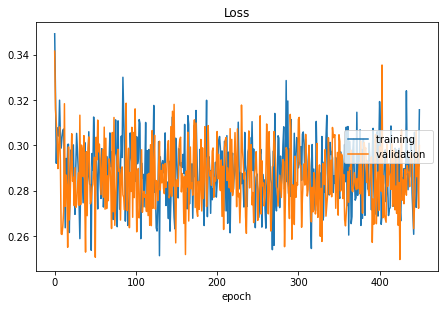

Loss
	training         	 (min:    0.251, max:    0.349, cur:    0.316)
	validation       	 (min:    0.250, max:    0.342, cur:    0.300)


In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

gc.collect()

model3 = Model3()

if torch.cuda.is_available():
    print("GPU available")
    model3.cuda()

train(model3, batch_size=32, learning_rate=1e-4, num_epochs=2, 
      ratios=(.825, .025, .15))


# Model 5 Training

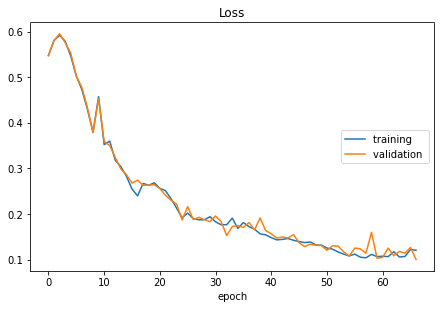

Loss
	training         	 (min:    0.104, max:    0.592, cur:    0.120)
	validation       	 (min:    0.100, max:    0.595, cur:    0.100)


KeyboardInterrupt: ignored

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

gc.collect()

model5 = Model5()

if torch.cuda.is_available():
    print("GPU available")
    model5.cuda()

train(model5, batch_size=32, learning_rate=1e-3, num_epochs=2, 
      ratios=(.8, .15, .05))

# Skip Encoder 1 Training

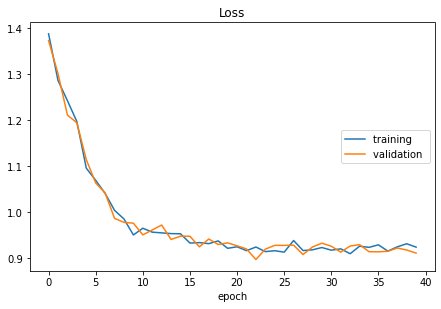

Loss
	training         	 (min:    0.910, max:    1.388, cur:    0.924)
	validation       	 (min:    0.897, max:    1.374, cur:    0.911)
Epoch    41: reducing learning rate of group 0 to 3.1250e-07.


KeyboardInterrupt: ignored

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

gc.collect()

skipenc1 = SkipEncoder1()

if torch.cuda.is_available():
    print("GPU available")
    skipenc1.cuda()

train(skipenc1, batch_size=6, learning_rate=2e-5, num_epochs=2, 
      ratios=(.8, .15, .05))

# Skip Encoder 2 Training

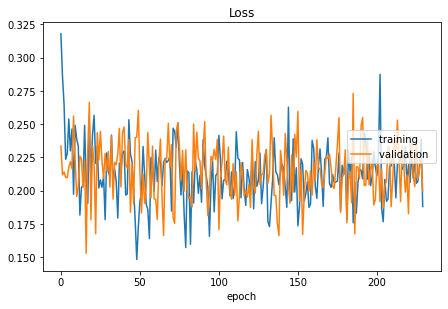

Loss
	training         	 (min:    0.148, max:    0.318, cur:    0.188)
	validation       	 (min:    0.153, max:    0.273, cur:    0.200)


KeyboardInterrupt: ignored

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

gc.collect()

skipenc2 = SkipEncoder2(activ=nn.ELU())

if torch.cuda.is_available():
    print("GPU available")
    skipenc2.cuda()

train(skipenc2, batch_size=4, learning_rate=1e-5, 
          num_epochs=1, ratios=(.8, .15, .05))

# Conditional GAN Training

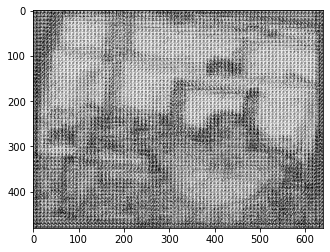

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

gc.collect()

gen = Generator2()
dis = Discriminator2()

print(sum(p.numel() for p in gen.parameters()))
print(sum(p.numel() for p in dis.parameters()))

if torch.cuda.is_available():
    print("GPU available")
    gen.cuda()
    dis.cuda()

trainGAN2(gen, dis, batch_size=32, gen_lr=4e-4, dis_lr=6e-4, 
          stepped_epochs=1000, num_epochs=5, ratios=(.8, .15, .05))
'''
trainGAN(gen2, dis1, batch_size=64, gen_lr=5e-4, dis_lr=8e-5, 
          with_turns=False, num_epochs=5, ratios=(.8, .15, .05))
'''

# SkipEncoder3 - Decoder Skip Connections

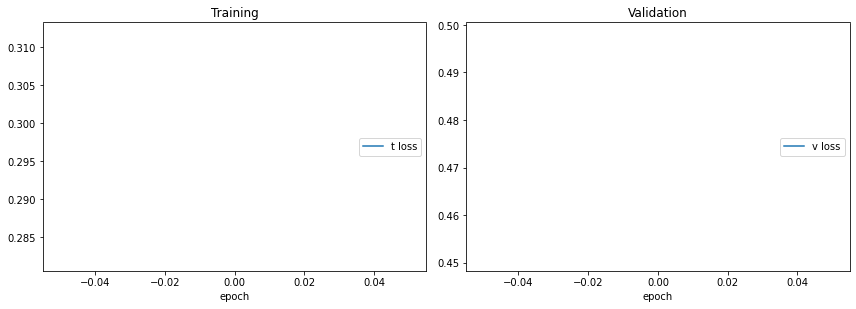

Training
	t loss           	 (min:    0.297, max:    0.297, cur:    0.297)
Validation
	v loss           	 (min:    0.474, max:    0.474, cur:    0.474)


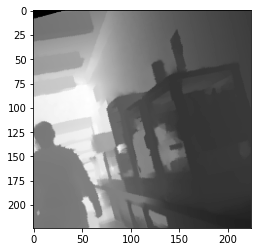

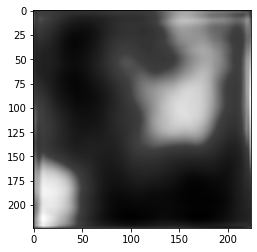

torch.Size([32, 3, 224, 224])
torch.Size([32, 32, 112, 112])
torch.Size([32, 16, 112, 112])
torch.Size([32, 24, 56, 56])
torch.Size([32, 24, 56, 56])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 32, 28, 28])
torch.Size([32, 64, 14, 14])
torch.Size([32, 64, 14, 14])
torch.Size([32, 64, 14, 14])
torch.Size([32, 64, 14, 14])
torch.Size([32, 96, 14, 14])
torch.Size([32, 96, 14, 14])
torch.Size([32, 96, 14, 14])
torch.Size([32, 160, 7, 7])
torch.Size([32, 160, 7, 7])
torch.Size([32, 160, 7, 7])
torch.Size([32, 320, 7, 7])
torch.Size([32, 1280, 7, 7])


KeyboardInterrupt: ignored

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

gc.collect()

skipenc3 = SkipEncoder3()

print(sum(p.numel() for p in skipenc3.parameters()))

if torch.cuda.is_available():
    print("GPU available")
    skipenc3.cuda()

train_aug(skipenc3, batch_size=32, lr=5e-4, num_epochs=5, ratios=(.8, .15, .05))

# SkipEncoder4 - EncToDec Skip Connections

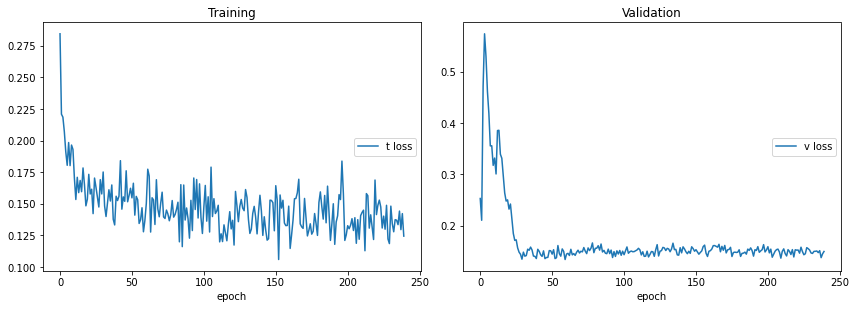

Training
	t loss           	 (min:    0.106, max:    0.284, cur:    0.124)
Validation
	v loss           	 (min:    0.134, max:    0.574, cur:    0.150)


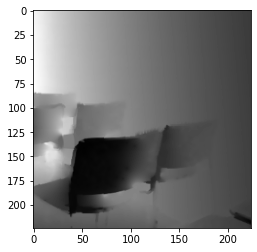

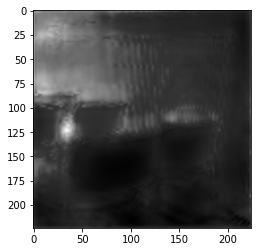

KeyboardInterrupt: ignored

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

gc.collect()

skipenc4 = SkipEncoder4()

print(sum(p.numel() for p in skipenc4.parameters()))

if torch.cuda.is_available():
    print("GPU available")
    skipenc4.cuda()

train_aug(skipenc4, batch_size=32, lr=5e-4, num_epochs=5, ratios=(.8, .15, .05))

# Result Checking

2527 542 542
torch.Size([64, 3, 224, 224]) torch.Size([64, 1, 224, 224])
min: 0.0, max: 0.9921568627450981, mean: 0.44509685857263076
min: 0.13835869195441222, max: 0.39058815146711523, mean: 0.1930245939818724
min: 0.2832838296890259, max: 0.4348311722278595, mean: 0.35084113478660583


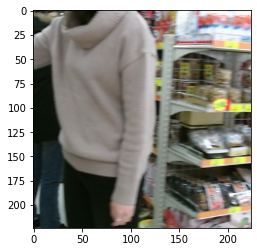

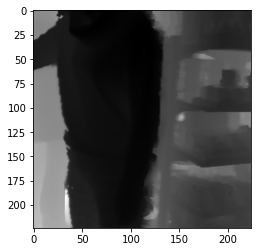

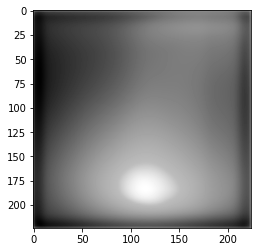

In [ ]:
def vecinfo(vec):
    totens = transforms.ToTensor()
    try:
        vec = totens(vec)
    except:
        pass
    print("min: {}, max: {}, mean: {}".format(
        torch.min(vec),
        torch.max(vec),
        torch.mean(vec)
    ))

train_loader, val_loader, test_loader = load_dataset_aug(
        file_path=darie_path,
        batch_size=64,
        ratios=(.7, .15, .15),
        shuffle=False
        )

for i, (rgb, depth) in enumerate(test_loader):

    print(rgb.shape, depth.shape)

    rgb1 = np.moveaxis(np.array(rgb[0]), 0, -1)
    depth1 = np.moveaxis(np.array(depth[0]), 0, -1).squeeze()

    #print(rgb1)

    transform = transforms.ToTensor()

    pred = np.array(skipenc3(transform(rgb1).cuda().float().unsqueeze(0)).detach().cpu()).squeeze()

    #print(depth1, pred)
    #print(torch.max(depth1), torch.min(depth1), torch.mean(depth1))
    vecinfo(rgb)
    vecinfo(depth1)
    vecinfo(pred)

    plt.imshow(rgb1)
    plt.show()
    plt.imshow(depth1, cmap='gray')
    plt.show()
    plt.imshow(pred, cmap='gray')
    plt.show()
    break

# GAN Result Checking

2527 542 542
torch.Size([64, 3, 224, 224]) torch.Size([64, 1, 224, 224])


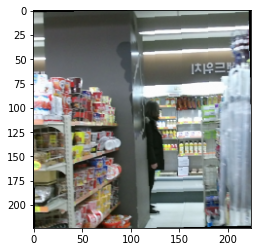

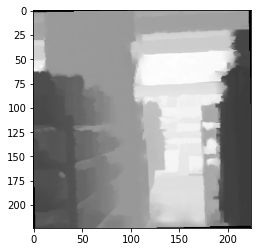

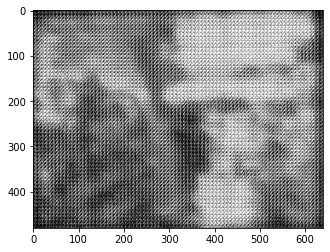

In [ ]:
train_loader, val_loader, test_loader = load_dataset_aug(
        file_path=darie_path,
        batch_size=64,
        ratios=(.7, .15, .15),
        shuffle=True
        )

for i, (rgb, depth) in enumerate(train_loader):

    print(rgb.shape, depth.shape)

    rgb1 = np.moveaxis(np.array(rgb[0]), 0, -1)
    depth1 = np.moveaxis(np.array(depth[0]), 0, -1).squeeze()

    transform = transforms.ToTensor()

    rgb = transform(rgb1).cuda().float().unsqueeze(0)

    pred = np.array(gen(rgb).detach().cpu()).squeeze()
    '''
    print(rgb)
    print(torch.min(rgb), torch.max(rgb))
    print(depth1)
    print(np.min(depth1), np.max(depth1))
    '''


    plt.imshow(rgb1)
    plt.show()
    plt.imshow(depth1, cmap='gray')
    plt.show()
    plt.imshow(pred, cmap='gray')
    plt.show()
    break

# Baseline Test

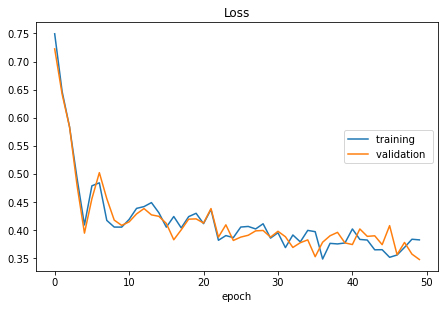

Loss
	training         	 (min:    0.348, max:    0.749, cur:    0.382)
	validation       	 (min:    0.347, max:    0.723, cur:    0.347)


KeyboardInterrupt: ignored

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

gc.collect()

bline1 = Baseline1()

if torch.cuda.is_available():
    print("GPU available")
    bline1.cuda()

train(bline1, batch_size=32, learning_rate=1e-4, num_epochs=1, 
      ratios=(.8, .15, .15))

2527 541 543
torch.Size([64, 3, 480, 640]) torch.Size([64, 1, 480, 640])
0.03170824750133516 0.011184863050278477


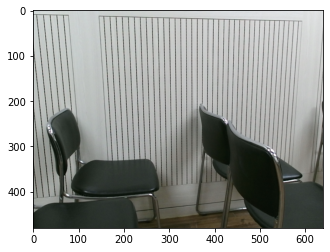

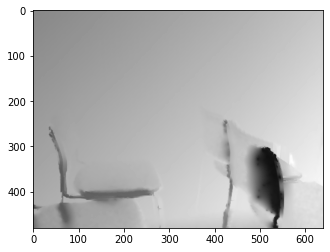

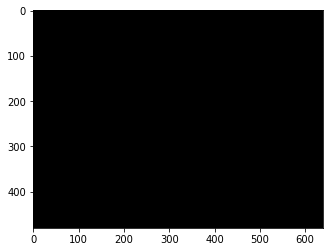

In [ ]:
train_loader, val_loader, test_loader = load_dataset(
        file_path=darie_path,
        batch_size=64,
        ratios=(.7, .15, .15),
        shuffle=False
        )

for i, (rgb, depth) in enumerate(test_loader):

    print(rgb.shape, depth.shape)

    rgb1 = np.moveaxis(np.array(rgb[0]), 0, -1)
    depth1 = np.moveaxis(np.array(depth[0]), 0, -1).squeeze()

    #print(rgb1)
    print(np.max(depth1), np.min(depth1))

    transform = transforms.ToTensor()

    #pred1 = np.array(bline1(transform(rgb1).cuda().float().unsqueeze(0)).detach().cpu()).squeeze()
    pred2 = np.array(model3(transform(rgb1).cuda().float().unsqueeze(0)).detach().cpu()).squeeze()

    plt.imshow(rgb1)
    plt.show()
    plt.imshow(depth1, cmap='gray')
    plt.show()
    #plt.imshow(pred1, cmap='gray')
    #plt.show()
    plt.imshow(pred2, cmap='gray')
    plt.show()
    break

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
model3 = Model3()
print(count_parameters(model3))

2171101


# Process Killing

In [ ]:
!ps -aux|grep python

root          23  0.3  0.8 424840 116296 ?       Sl   16:29   1:15 /usr/bin/python2 /usr/local/bin/jupyter-notebook --ip="172.28.0.2" --port=9000 --FileContentsManager.root_dir="/" --MappingKernelManager.root_dir="/content"
root        3388 49.4 25.1 43244060 3356536 ?    Ssl  19:27  85:01 /usr/bin/python3 -m ipykernel_launcher -f /root/.local/share/jupyter/runtime/kernel-1a5c0d0f-d6f8-4368-b45e-48643ccb33d6.json
root        6353  0.0  0.0  39196  6420 ?        S    22:19   0:00 /bin/bash -c ps -aux|grep python
root        6355  0.0  0.0   5708   436 ?        D    22:19   0:00 grep python


In [ ]:
!kill -9 3388